# Location Intelligence Data Clustering

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
np.random.seed = 42

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('./DATA/google_places_data.csv')

# Feature Engineering

#### Deleting duplicated rows

In [3]:
df = df.drop_duplicates(subset=['business_id'])

#### Outliers

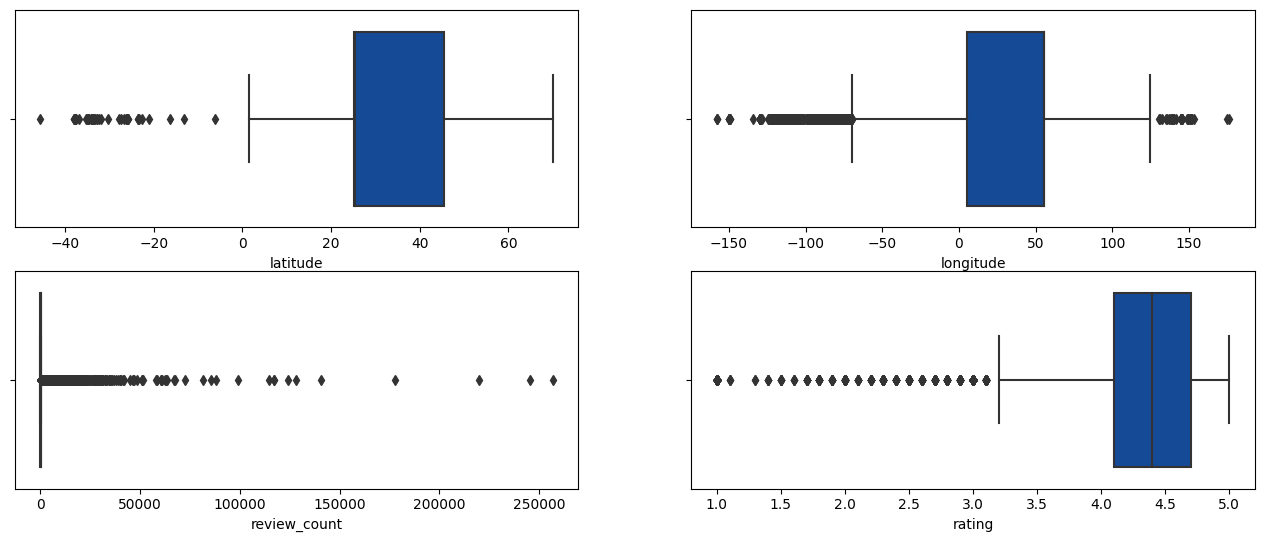

In [4]:
plt.figure(figsize = (16,13))

for i, col in enumerate(['latitude', 'longitude', 'review_count', 'rating']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = df, color='#0047AB')
plt.show()

##### Cutting off review_count

In [5]:
review_count_count = df["review_count"].value_counts().reset_index(name='count')
review_count_count = review_count_count[review_count_count['count'] > 100]
review_count_count

,review_count,count
0,32.0,2738
1,1.0,1055
2,2.0,713
3,3.0,543
4,4.0,412
5,5.0,334
6,6.0,255
7,7.0,252
8,8.0,236
9,9.0,218


C:\Users\okroj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


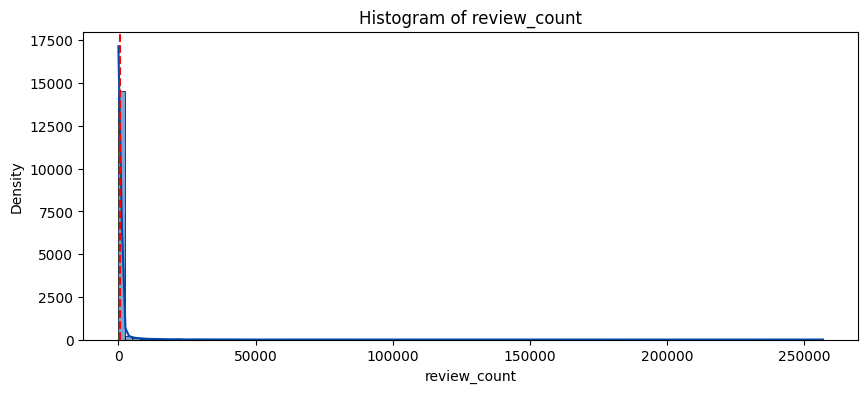

Value above which highest 10% of the data falls: 565.0


In [5]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')

highest_10_percent = df['review_count'].quantile(0.90)
plt.axvline(x=highest_10_percent, color='red', linestyle='--')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()
print("Value above which highest 10% of the data falls:", highest_10_percent)

In [7]:
df.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent

C:\Users\okroj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


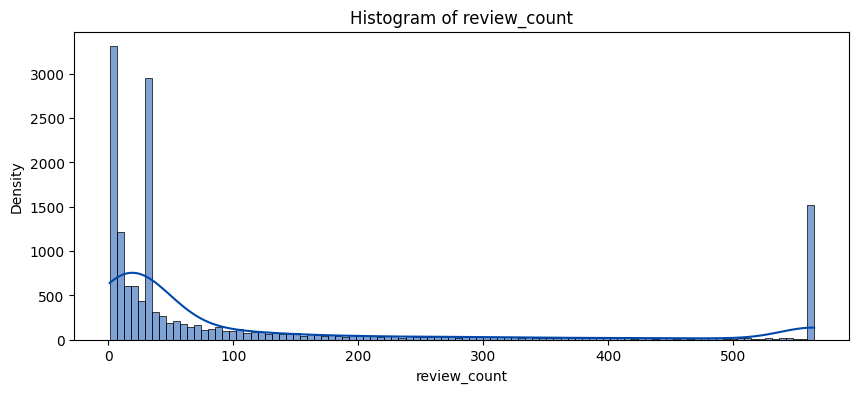

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()

In [9]:
# nie usuwałabym rating te niskie oceny mogą być dość istotne dla modelu

##### Cutting off rating

In [10]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['rating'], bins=41, kde=True, color='#bb2e00', edgecolor='black')

# lowest_2_percent = df['rating'].quantile(0.02)
# plt.axvline(x=lowest_2_percent, color='red', linestyle='--')
# plt.title('Histogram of rating')
# plt.xlabel('rating')
# plt.ylabel('Density')
# plt.show()
# print("Value above which lowest 2% of the data falls:", lowest_2_percent)

In [11]:
# df.loc[df['rating'] < lowest_2_percent, 'rating'] = lowest_2_percent

In [12]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['rating'], bins=29, kde=True, color='#bb2e00', edgecolor='black')
# plt.title('Histogram of rating')
# plt.xlabel('rating')
# plt.ylabel('Density')
# plt.show()

### Dividing types column

In [13]:
df_expanded = df.copy()
df_expanded = df_expanded['types'].str.split(', ', expand=True)
row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
df["type_list"] = row_list
#X = X_train.explode('type_list', ignore_index = True)
one_hot_encoded  = pd.get_dummies(df.explode('type_list', ignore_index = True)['type_list'])
joined_df = df.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
types_columns = joined_df.groupby("business_id", as_index=False).any()

df_expanded = df.copy()
df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
type_counts = df_expanded['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']
type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
unique_types = type_counts["Type"].unique()
columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
types_columns = types_columns.drop(columns=columns_to_drop)

df = pd.merge(df, types_columns, on='business_id')
df = df.drop(columns=['type_list'])
df.head()

#### Column removal

In [18]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
business_id,15108
phone_number,11282
name,14192
full_address,14737
latitude,14418
...,...
Veterinarian,2
Vitamin & supplements store,2
Wine store,2
Women's clothing store,2


In [19]:
df = df.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])

Some categorical columns have values that are mostly unique to each record in the dataset. As a result, they will not be valuable for our model and we decided to remove them. 

Removed columns: 
* business_id
* phone_number	
* name	
* full_address 
* place_id 
* place_link	

In [20]:
df = df.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])

From the EDA stage, we know that the columns related to business operating hours are highly correlated with each other, so we have decided to remove these columns as well.

In [21]:
df = df.drop(columns=['geo_cluster'])

We decided to remove the geo_cluster column, which resulted from a previous clustering performed on the data.

In [22]:
df.shape

(15108, 162)

In [23]:
df.head()

,latitude,longitude,review_count,rating,timezone,website,types,Friday,Saturday,Sunday,...,Travel agency,University,Used car dealer,Used truck dealer,Van rental agency,Veterinarian,Vitamin & supplements store,Wine store,Women's clothing store,Zoo
0,23.733973,53.980629,58.0,4.7,Asia/Dubai,Unknown,Museum,2-6 PM,10 AM-6 PM,10 AM-6 PM,...,False,False,False,False,False,False,False,False,False,False
1,23.657332,53.741881,3.0,3.0,Asia/Dubai,Unknown,Museum,Open 24 hours,Open 24 hours,Open 24 hours,...,False,False,False,False,False,False,False,False,False,False
2,23.611601,58.593728,565.0,4.6,Asia/Muscat,https://www.nm.gov.om/,"National museum, Museum, Tourist attraction",2-6 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False
3,53.477136,-2.254582,565.0,4.4,Europe/London,https://www.scienceandindustrymuseum.org.uk/,"Science museum, Heritage museum, Museum, Touri...",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False
4,54.884752,-1.659321,565.0,4.8,Europe/London,https://www.beamish.org.uk/,"Open air museum, Museum, Tourist attraction",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False


### Train, Validation and Test Sets

In [24]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_val = train_test_split(X_dev, test_size=0.3, random_state=42)

## Feature engineering pipeline

In [16]:
def cutOffReviewCount(data):
    highest_10_percent = data['review_count'].quantile(0.90)
    data.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent
    return data

def cutOffRating(data):
    highest_2_percent = data['rating'].quantile(0.98)
    data.loc[df['rating'] > highest_2_percent, 'rating'] = highest_2_percent
    return data

def dropDuplicatedRows(data):
    data = data.drop_duplicates(subset=['business_id'])
    return data

def divingTypesColumn(data):
    df_expanded = data.copy()
    df_expanded = df_expanded['types'].str.split(', ', expand=True)
    row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
    data["type_list"] = row_list
    one_hot_encoded  = pd.get_dummies(data.explode('type_list', ignore_index = True)['type_list'])
    joined_df = data.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
    types_columns = joined_df.groupby("business_id", as_index=False).any()
    
    df_expanded = data.copy()
    df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
    type_counts = df_expanded['type'].value_counts().reset_index()
    type_counts.columns = ['Type', 'Count']
    type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
    unique_types = type_counts["Type"].unique()
    columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
    types_columns = types_columns.drop(columns=columns_to_drop)
    
    data = pd.merge(data, types_columns, on='business_id')
    data = data.drop(columns=['type_list'])
    return data

def dropUniqueColumns(data):
    data = data.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])
    return data

def dropDayTimeColumns(data):
    data = data.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])
    return data

def dropGeoCluster(data):
    data = data.drop(columns=['geo_cluster'])
    return data


feature_engineering_pipeline = Pipeline([
    ('cutOffReviewCount', FunctionTransformer(cutOffReviewCount)),
    ('cutOffRating', FunctionTransformer(cutOffRating)),
    ('dropDuplicatedRows', FunctionTransformer(dropDuplicatedRows)),
    ('divingTypesColumn', FunctionTransformer(divingTypesColumn)),
    ('dropUniqueColumns', FunctionTransformer(dropUniqueColumns)),
    ('dropDayTimeColumns', FunctionTransformer(dropDayTimeColumns)),
    ('dropGeoCluster', FunctionTransformer(dropGeoCluster))
])

In [17]:
df = feature_engineering_pipeline.transform(df)

In [18]:
df

,latitude,longitude,review_count,rating,timezone,website,types,Friday,Saturday,Sunday,...,Travel agency,University,Used car dealer,Used truck dealer,Van rental agency,Veterinarian,Vitamin & supplements store,Wine store,Women's clothing store,Zoo
0,23.733973,53.980629,58.0,4.7,Asia/Dubai,Unknown,Museum,2-6 PM,10 AM-6 PM,10 AM-6 PM,...,False,False,False,False,False,False,False,False,False,False
1,23.657332,53.741881,3.0,3.0,Asia/Dubai,Unknown,Museum,Open 24 hours,Open 24 hours,Open 24 hours,...,False,False,False,False,False,False,False,False,False,False
2,23.611601,58.593728,565.0,4.6,Asia/Muscat,https://www.nm.gov.om/,"National museum, Museum, Tourist attraction",2-6 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False
3,53.477136,-2.254582,565.0,4.4,Europe/London,https://www.scienceandindustrymuseum.org.uk/,"Science museum, Heritage museum, Museum, Touri...",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False
4,54.884752,-1.659321,565.0,4.8,Europe/London,https://www.beamish.org.uk/,"Open air museum, Museum, Tourist attraction",10 AM-5 PM,10 AM-5 PM,10 AM-5 PM,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15103,25.393262,55.432665,32.0,4.4,Asia/Dubai,Unknown,Van rental agency,Hours not available,Hours not available,Hours not available,...,False,False,False,False,True,False,False,False,False,False
15104,25.377181,55.464124,32.0,4.4,Asia/Dubai,Unknown,Car rental agency,Hours not available,Hours not available,Hours not available,...,False,False,False,False,False,False,False,False,False,False
15105,25.389579,55.459804,32.0,4.4,Asia/Dubai,Unknown,Car leasing service,Hours not available,Hours not available,Hours not available,...,False,False,False,False,False,False,False,False,False,False
15106,25.163250,55.418791,32.0,4.4,Asia/Dubai,Unknown,Car rental agency,Hours not available,Hours not available,Hours not available,...,False,False,False,False,False,False,False,False,False,False
